# Setup cell model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload
import torch
import time
import doobhtransform.core as doob
from doobhtransform.utils import normal_logpdf
from particlefilter.core import simulate_uncontrolled_SMC, simulate_controlled_SMC

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing on " + str(device))

Computing on cpu


In [4]:
# tuning parameters
d = 2 # dimension of latent state
std_obs = 1.0
theta = {
    "alpha": torch.tensor(1.0),
    "beta": torch.tensor(1.0),
    "kappa": torch.tensor(1.0),
    "xi": torch.tensor(0.5),
}
M = 50  # number of time-discretization steps

# Latent process

In [5]:
# dict for objects relating to latent process
state = {}

# dimension of state
state["dim"] = d

# drift of diffusion
def b(theta, x):
    P = torch.tensor(4.0)
    out = torch.zeros(x.shape)
    out[:, 0] = (
        theta["alpha"] * x[:, 0]**P / (theta["xi"]**P + x[:, 0]**P)
        + theta["beta"] * theta["xi"]**P / (theta["xi"]**P + x[:, 1]**P)
        - theta["kappa"] * x[:, 0]
    )
    out[:, 1] = (
        theta["alpha"] * x[:, 1]**P / (theta["xi"]**P + x[:, 1]**P)
        + theta["beta"] * theta["xi"]**P / (theta["xi"]**P + x[:, 0]**P)
        - theta["kappa"] * x[:, 1]
    )
    return out
state["drift"] = b

# diffusion coefficient of diffusion
sigma = torch.tensor(1.0, device=device)
state["sigma"] = sigma

# Observation model

In [6]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs["dim"] = p

# number of observations
T = 10
obs["num_obs"] = T

# observation time interval
interval = 1.0
obs["interval"] = interval

# observation parameters
var_obs = torch.tensor(std_obs**2, device=device)  # variance of observation

# log-observation density
obs_log_density = lambda theta, x, y: normal_logpdf(
    y, x, var_obs
)  # terminal condition, returns size (N)
obs["log_density"] = obs_log_density

# Simulate states and observations

In [7]:
# simulate states and observations from model
X0 = torch.ones(1, d)
X = X0.clone()
J = 2000
max_index = J * M + 1
store_states = torch.zeros(J * M + 1, d, device=device)
store_states[0, :] = X
store_obs = torch.zeros(J * M, d, device=device)
stepsize = torch.tensor(T / M, device=device)
for j in range(J):
    for m in range(M):
        euler = X + stepsize * b(theta, X)
        W = torch.sqrt(stepsize) * torch.randn(X.shape, device=device)
        X = euler + sigma * W
        Y = X + torch.sqrt(var_obs) * torch.randn(1, p, device=device)
        index = j * M + m + 1
        store_states[index, :] = X
        store_obs[index - 1, :] = Y

# learning standardization means and standard deviations
standardization = {
    "x_mean": torch.mean(store_states, 0),
    "x_std": torch.std(store_states, 0),
    "y_mean": torch.mean(store_obs, 0),
    "y_std": torch.std(store_obs, 0),
}
print(standardization)

# simulate initial states
rinit = lambda N: store_states[
    torch.randint(0, max_index, size=(N,)), :
]  # function to subsample states
state["rinit"] = rinit


# simulate observations
def observation(N):
    X = rinit(N)  # (N, d)
    Y = torch.zeros(N, T, p, device=device)
    for t in range(T):
        for m in range(M):
            W = torch.sqrt(stepsize) * torch.randn(N, d, device=device)  # size (N, d)
            X = X + stepsize * b(theta, X) + sigma * W
        Y[:, t, :] = X + torch.sqrt(var_obs) * torch.randn(N, p, device=device)
    return Y
obs["robs"] = observation

{'x_mean': tensor([0.9842, 1.0120]), 'x_std': tensor([0.9370, 0.9480]), 'y_mean': tensor([0.9874, 1.0129]), 'y_std': tensor([1.3685, 1.3732])}


# Train model

In [9]:
# algorithm settings
num_steps = M
V_net_config = {"layers": [16], "standardization": standardization, "full_obs": True}
Z_net_config = {
    "layers": [d + 16],
    "standardization": standardization,
    "full_obs": True,
}
net_config = {"V": V_net_config, "Z": Z_net_config}
model = doob.model(state, obs, num_steps, net_config, device)

# optimization configuration
optim_config = {
    "minibatch": 100,
    "num_iterations": 1000,
    "learning_rate": 1e-2,
    "weight_decay": 1e-2,
    "initial_required": True,
}

# training
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 1/1000 [00:00<07:48,  2.13it/s]

Optimization iteration: 1 Loss: 284.15948486328125


 10%|█         | 100/1000 [00:37<05:33,  2.70it/s]

Optimization iteration: 100 Loss: 70.62055969238281


 20%|██        | 200/1000 [01:15<05:04,  2.63it/s]

Optimization iteration: 200 Loss: 16.096813201904297


 30%|███       | 300/1000 [01:54<04:31,  2.58it/s]

Optimization iteration: 300 Loss: 12.360576629638672


 40%|████      | 400/1000 [02:33<04:01,  2.49it/s]

Optimization iteration: 400 Loss: 9.059097290039062


 50%|█████     | 500/1000 [03:13<03:21,  2.49it/s]

Optimization iteration: 500 Loss: 8.187411308288574


 60%|██████    | 600/1000 [03:53<02:37,  2.54it/s]

Optimization iteration: 600 Loss: 7.972987651824951


 70%|███████   | 700/1000 [04:32<01:57,  2.56it/s]

Optimization iteration: 700 Loss: 6.4676713943481445


 80%|████████  | 800/1000 [05:11<01:18,  2.55it/s]

Optimization iteration: 800 Loss: 6.513869762420654


 90%|█████████ | 900/1000 [05:50<00:39,  2.54it/s]

Optimization iteration: 900 Loss: 5.827389717102051


100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s]

Optimization iteration: 1000 Loss: 4.968928813934326
Training time (secs): 395.57185983657837


In [78]:
# more training
optim_config["initial_required"] = False
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 1/1000 [00:00<05:37,  2.96it/s]

Optimization iteration: 1 Loss: 11.082398414611816


 10%|█         | 100/1000 [00:34<05:05,  2.95it/s]

Optimization iteration: 100 Loss: 10.435173034667969


 20%|██        | 200/1000 [01:08<04:30,  2.95it/s]

Optimization iteration: 200 Loss: 10.69056510925293


 30%|███       | 300/1000 [01:42<03:55,  2.98it/s]

Optimization iteration: 300 Loss: 9.986132621765137


 40%|████      | 400/1000 [02:16<03:24,  2.94it/s]

Optimization iteration: 400 Loss: 9.795231819152832


 50%|█████     | 500/1000 [02:50<02:49,  2.96it/s]

Optimization iteration: 500 Loss: 10.2233304977417


 60%|██████    | 600/1000 [03:25<02:23,  2.78it/s]

Optimization iteration: 600 Loss: 10.401351928710938


 70%|███████   | 700/1000 [04:00<01:43,  2.89it/s]

Optimization iteration: 700 Loss: 9.655078887939453


 80%|████████  | 800/1000 [04:34<01:08,  2.90it/s]

Optimization iteration: 800 Loss: 9.120218276977539


 90%|█████████ | 900/1000 [05:08<00:33,  2.98it/s]

Optimization iteration: 900 Loss: 9.822768211364746


100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]

Optimization iteration: 1000 Loss: 9.751876831054688
Training time (secs): 342.42083621025085


# Run SMC

In [10]:
N = 2**10

In [11]:
Y = observation(1).squeeze()

In [13]:
_states, _ess, _log_norm_const, _log_ratio_norm_const = (
    simulate_uncontrolled_SMC(model, theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(_log_ratio_norm_const)))

Log-likelihood estimate: -33.354331970214844


In [14]:
states, ess, log_norm_const, log_ratio_norm_const = simulate_controlled_SMC(
    model, theta, X0, Y, N, resample=True, full_path=True
)
print("Log-likelihood estimate: " + str(float(log_ratio_norm_const)))

Log-likelihood estimate: -33.50495147705078


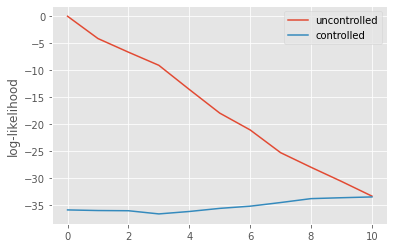

In [15]:
plt.figure()
plt.plot(_log_norm_const)
plt.plot(log_norm_const)
plt.ylabel("log-likelihood")
plt.legend(["uncontrolled", "controlled"])

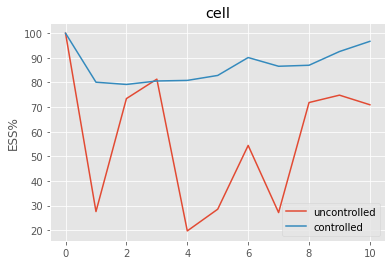

In [18]:
plt.figure()
plt.plot(_ess * 100 / N)
plt.plot(ess * 100 / N)
plt.title("cell")
plt.ylabel("ESS%")
plt.legend(["uncontrolled", "controlled"])

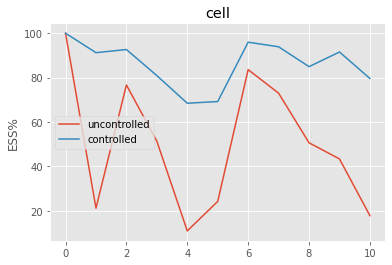

In [ ]:
plt.figure()
plt.plot(_ess * 100 / N)
plt.plot(ess * 100 / N)
plt.title("cell")
plt.ylabel("ESS%")
plt.legend(["uncontrolled", "controlled"])

In [86]:
# # plot states and observations (for full_path = False)
# times = torch.linspace(0.0, T * interval, T * M + 1, device=device)
# plt.figure()
# plt.plot(torch.arange(T + 1), X[:, 0], "r-")
# plt.plot(torch.arange(1, T + 1), Y[:, 0], "bx")
# plt.plot(times, torch.mean(states[:, :, 0], 0), "k-")
# plt.plot(times, torch.mean(_states[:, :, 0], 0), 'c-')
# # for n in range(N):
#     # plt.plot(times, states[n, :, 0], 'k.', alpha = 0.01)
# plt.xlabel("step", fontsize=15)
# plt.legend(["state", "observation", "uncontrolled mean", "controlled mean"], fontsize=15)
# plt.show()